THIS NOTEBOOK CONTAINS:
1. CONVERSION OF DEXINED MODEL FROM PYTORCH TO KERAS
2. INFERENCE OF DEXINED MODEL
3. POSTPROCESSING METHODS WHICH INCLUDES (leaf area, orientation, leaf centre, distance of leaf from plant)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from time import time
import argparse
import os
import random
import cv2
import torch.optim as optim
from torch.utils.data import DataLoader
from  torch.cuda.amp import autocast
from torch.cuda.amp import GradScaler,autocast
from torch.autograd import Variable
import numpy as np
import pickle

In [ ]:
def weight_init(m):
    if isinstance(m, (nn.Conv2d,)):
        # print("Applying custom weight initialization for nn.Conv2d layer...")
        # torch.nn.init.kaiming_uniform_(m.weight, a=0, mode='fan_in', nonlinearity='leaky_relu')
        torch.nn.init.xavier_normal_(m.weight, gain=1.0)
        # torch.nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
        # torch.nn.init.normal_(m.weight, mean=0, std=0.01)
        if m.weight.data.shape[1] == torch.Size([1]):
            torch.nn.init.normal_(m.weight, mean=0.0,)
        if m.weight.data.shape == torch.Size([1, 6, 1, 1]):
            torch.nn.init.constant_(m.weight, 0.2) # for fuse conv
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

    # for fusion layer
    if isinstance(m, (nn.ConvTranspose2d,)):
        torch.nn.init.xavier_normal_(m.weight, gain=1.0)
        # torch.nn.init.kaiming_uniform_(m.weight, a=0, mode='fan_in', nonlinearity='leaky_relu')
        # torch.nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
        # torch.nn.init.normal_(m.weight, mean=0, std=0.01)
        if m.weight.data.shape[1] == torch.Size([1]):
            torch.nn.init.normal_(m.weight, std=0.1)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

DEFINING THE MODEL ARCHITECTURE

In [ ]:
class _DenseLayer(nn.Sequential):
    def __init__(self, input_features, out_features):
        super(_DenseLayer, self).__init__()

        # self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv2d(input_features, out_features,
                                           kernel_size=1, stride=1, padding=1, bias=True)),
        self.add_module('norm1', nn.BatchNorm2d(out_features)),
        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv2d(out_features, out_features,
                                           kernel_size=3, stride=1, bias=True)),
        self.add_module('norm2', nn.BatchNorm2d(out_features))
        # double check the norm1 comment if necessary and put norm after conv2

    def forward(self, x):
        x1, x2 = x

        new_features = super(_DenseLayer, self).forward(F.relu(x1))  # F.relu()
        # if new_features.shape[-1]!=x2.shape[-1]:
        #     new_features =F.interpolate(new_features,size=(x2.shape[2],x2.shape[-1]), mode='bicubic',
        #                                 align_corners=False)
        return 0.5 * (new_features + x2), x2

class _DenseBlock(nn.Sequential):
    def __init__(self, num_layers, input_features, out_features):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(input_features, out_features)
            self.add_module('denselayer%d' % (i + 1), layer)
            input_features = out_features

# class SqueezeExcitation(nn.Module):
#     def __init__(self, nb_channels, reduction=16):
#         super(SqueezeExcitation, self).__init__()
#         self.nb_channels=nb_channels
#         self.avg_pool=nn.AdaptiveAvgPool2d(1)
#         self.fc=nn.Sequential(
#                 nn.Linear(nb_channels, nb_channels // reduction),
#                 nn.ReLU(inplace=True),
#                 nn.Linear(nb_channels // reduction, nb_channels),
#                 nn.Sigmoid())

        
#     def forward(self, x):
#         y = self.avg_pool(x).view(-1,self.nb_channels)
#         y = self.fc(y).view(-1,self.nb_channels,1,1)
#         return x * y

class UpConvBlock(nn.Module):
    def __init__(self, in_features, up_scale):
        super(UpConvBlock, self).__init__()
        self.up_factor = 2
        self.constant_features = 16

        layers = self.make_deconv_layers(in_features, up_scale)
        assert layers is not None, layers
        self.features = nn.Sequential(*layers)

    def make_deconv_layers(self, in_features, up_scale):
        layers = []
        all_pads=[0,0,1,3,7]
        for i in range(up_scale):
            kernel_size = 2 ** up_scale
            pad = all_pads[up_scale]  # kernel_size-1
            out_features = self.compute_out_features(i, up_scale)
            layers.append(nn.Conv2d(in_features, out_features, 1))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.ConvTranspose2d(
                out_features, out_features, kernel_size, stride=2, padding=pad))
            in_features = out_features
        return layers

    def compute_out_features(self, idx, up_scale):
        return 1 if idx == up_scale - 1 else self.constant_features

    def forward(self, x):
        return self.features(x)

class SingleConvBlock(nn.Module):
    def __init__(self, in_features, out_features, stride,
                 use_bs=True
                 ):
        super(SingleConvBlock, self).__init__()
        self.use_bn = use_bs
        self.conv = nn.Conv2d(in_features, out_features, 1, stride=stride,
                              bias=True)
        self.bn = nn.BatchNorm2d(out_features)

    def forward(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.bn(x)
        return x


class DoubleConvBlock(nn.Module):
    def __init__(self, in_features, mid_features,
                 out_features=None,
                 stride=1,
                 use_act=True):
        super(DoubleConvBlock, self).__init__()

        self.use_act = use_act
        if out_features is None:
            out_features = mid_features
        self.conv1 = nn.Conv2d(in_features, mid_features,
                               3, padding=1, stride=stride)
        self.bn1 = nn.BatchNorm2d(mid_features)
        self.conv2 = nn.Conv2d(mid_features, out_features, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_features)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.use_act:
            x = self.relu(x)
        return x

In [ ]:
class DexiNed(nn.Module):
    """ Definition of the DXtrem network. """

    def __init__(self):
        super(DexiNed, self).__init__()
        self.block_1 = DoubleConvBlock(3, 32, 64, stride=2,)
        self.block_2 = DoubleConvBlock(64, 128, use_act=False)
        self.dblock_3 = _DenseBlock(2, 128, 256)
        self.dblock_4 = _DenseBlock(3, 256, 512)
        self.dblock_5 = _DenseBlock(3, 512, 512)
        self.dblock_6 = _DenseBlock(3, 512, 256)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # left skip connections, figure in Journal
        self.side_1 = SingleConvBlock(64, 128, 2)
        self.side_2 = SingleConvBlock(128, 256, 2)
        self.side_3 = SingleConvBlock(256, 512, 2)
        self.side_4 = SingleConvBlock(512, 512, 1)
        self.side_5 = SingleConvBlock(512, 256, 1)

        # right skip connections, figure in Journal
        self.pre_dense_2 = SingleConvBlock(128, 256, 2, use_bs=False)
        self.pre_dense_3 = SingleConvBlock(128, 256, 1)
        self.pre_dense_4 = SingleConvBlock(256, 512, 1)
        self.pre_dense_5_0 = SingleConvBlock(256, 512, 2,use_bs=False)
        self.pre_dense_5 = SingleConvBlock(512, 512, 1)
        self.pre_dense_6 = SingleConvBlock(512, 256, 1)

        # USNet
        self.up_block_1 = UpConvBlock(64, 1)
        self.up_block_2 = UpConvBlock(128, 1)
        self.up_block_3 = UpConvBlock(256, 2)
        self.up_block_4 = UpConvBlock(512, 3)
        self.up_block_5 = UpConvBlock(512, 4)
        self.up_block_6 = UpConvBlock(256, 4)
        self.block_cat = SingleConvBlock(6, 1, stride=1, use_bs=False)

        self.apply(weight_init)

    def slice(self, tensor, slice_shape):
        t_shape = tensor.shape
        height, width = slice_shape
        if t_shape[-1]!=slice_shape[-1]:
            new_tensor = F.interpolate(
                tensor, size=(height, width), mode='bicubic',align_corners=False)
        else:
            new_tensor=tensor
        # tensor[..., :height, :width]
        return new_tensor

    def forward(self, x):
        assert x.ndim == 4, x.shape

        # Block 1
        # print(f"x shape           : {x.shape}")
        block_1 = self.block_1(x)
        # print(f"block_1 shape     : {block_1.shape}")
        block_1_side = self.side_1(block_1)
        # print(f"block_1_side shape: {block_1_side.shape}")

        # Block 2
        block_2 = self.block_2(block_1)
        block_2_down = self.maxpool(block_2)
        block_2_add = block_2_down + block_1_side
        block_2_side = self.side_2(block_2_add)

        # Block 3
        block_3_pre_dense = self.pre_dense_3(block_2_down)
        block_3, _ = self.dblock_3([block_2_add, block_3_pre_dense])
        block_3_down = self.maxpool(block_3)
        block_3_add = block_3_down + block_2_side
        block_3_side = self.side_3(block_3_add)

        # Block 4
        block_4_pre_dense_256 = self.pre_dense_2(block_2_down)
        block_4_pre_dense = self.pre_dense_4(
            block_4_pre_dense_256 + block_3_down)
        block_4, _ = self.dblock_4([block_3_add, block_4_pre_dense])
        block_4_down = self.maxpool(block_4)
        block_4_add = block_4_down + block_3_side
        block_4_side = self.side_4(block_4_add)

        # Block 5
        block_5_pre_dense_512 = self.pre_dense_5_0(block_4_pre_dense_256)
        block_5_pre_dense = self.pre_dense_5(
            block_5_pre_dense_512 + block_4_down)
        block_5, _ = self.dblock_5([block_4_add, block_5_pre_dense])
        block_5_add = block_5 + block_4_side

        # Block 6
        block_6_pre_dense = self.pre_dense_6(block_5)
        block_6, _ = self.dblock_6([block_5_add, block_6_pre_dense])

        # upsampling blocks
        # height, width = x.shape[-2:]
        # slice_shape = (height, width)
        # out_1 = self.slice(self.up_block_1(block_1), slice_shape)
        out_1 = self.up_block_1(block_1)
        out_2 = self.up_block_2(block_2)
        out_3 = self.up_block_3(block_3)
        out_4 = self.up_block_4(block_4)
        out_5 = self.up_block_5(block_5)
        out_6 = self.up_block_6(block_6)
        results = [out_1, out_2, out_3, out_4, out_5, out_6]
        # print(out_1.shape,out_2.shape,out_3.shape,out_4.shape,out_5.shape,out_6.shape)
        # print(results.shape)

        # concatenate multiscale outputs
        block_cat = torch.cat(results, dim=1)  # Bx6xHxW
        block_cat = self.block_cat(block_cat)  # Bx1xHxW

        # return results
        results.append(block_cat)
        return results


CONVERSION OF PYTORCH MODEL INTO KERAS USING ONNX

In [ ]:
import torch.onnx
import onnx
import tensorflow as tf
# print(tf.__version__)
# from onnx_tf.backend import prepare

In [ ]:
# !pip install  onnx-tf==1.5.0
# !pip install onnx
!pip install onnx2keras
# !pip install onnx_tf==1.5.0
# !pip install tensorflow==2.2
# tf.__version__
# !pip install pytorch2keras 

  Created wheel for onnx2keras: filename=onnx2keras-0.0.24-cp37-none-any.whl size=24582 sha256=219a3a031474a53d2de5063e1ca3d2896bbe12253f7393a43f05f23d04ae27cd
  Stored in directory: /root/.cache/pip/wheels/1d/d2/0a/8310ecf5f80355546fadda0fb4c611c8b54a63fce9af555155
Successfully built onnx2keras


LOAD THE MODEL TO BE CONVERTED

In [ ]:
device = "cuda"
model = DexiNed().to(device)
checkpoint_path = '/content/drive/My Drive/basil_leaves/model_weights/apex&grad_dexined__parameter_red_epoch35_dc_0.24_fixeddataset.pth'
model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device(device)))


<All keys matched successfully>

Exporting pytorch model into .onnx format

In [ ]:
batch_size=1
x = torch.randn(batch_size, 3, 400, 400, requires_grad=True, device=device)
torch.onnx.export(model,x,'/content/drive/My Drive/basil_leaves/model_weights/onnx_apex&grad_dexined__parameter_red_epoch35_dc_0.24_fixeddataset_400patch.onnx',
                  input_names=['main_input'], output_names=['main_output'])

## to check if onnx is loading properly
onnx_model = onnx.load('/content/drive/My Drive/basil_leaves/model_weights/onnx_apex&grad_dexined__parameter_red_epoch35_dc_0.24_fixeddataset_400patch.onnx')
onnx.checker.check_model(onnx_model)

Converting onnx model into keras model

In [ ]:
from onnx2keras import onnx_to_keras
modeltf = onnx.load('/content/drive/My Drive/basil_leaves/model_weights/onnx_apex&grad_dexined__parameter_red_epoch35_dc_0.24_fixeddataset_400patch.onnx') # Load the ONNX file
# tf_rep = prepare(modeltf)
k_model = onnx_to_keras(modeltf, ['main_input'])

INFO:onnx2keras:Converter is called.
DEBUG:onnx2keras:List input shapes:
DEBUG:onnx2keras:None
DEBUG:onnx2keras:List inputs:
DEBUG:onnx2keras:Input 0 -> main_input.
DEBUG:onnx2keras:List outputs:
DEBUG:onnx2keras:Output 0 -> main_output.
DEBUG:onnx2keras:Output 1 -> 469.
DEBUG:onnx2keras:Output 2 -> 475.
DEBUG:onnx2keras:Output 3 -> 484.
DEBUG:onnx2keras:Output 4 -> 496.
DEBUG:onnx2keras:Output 5 -> 508.
DEBUG:onnx2keras:Output 6 -> 510.
DEBUG:onnx2keras:Gathering weights to dictionary.
DEBUG:onnx2keras:Found weight 512 with shape (32, 3, 3, 3).
DEBUG:onnx2keras:Found weight 513 with shape (32,).
DEBUG:onnx2keras:Found weight 515 with shape (64, 32, 3, 3).
DEBUG:onnx2keras:Found weight 516 with shape (64,).
DEBUG:onnx2keras:Found weight 518 with shape (128, 64, 1, 1).
DEBUG:onnx2keras:Found weight 519 with shape (128,).
DEBUG:onnx2keras:Found weight 521 with shape (128, 64, 3, 3).
DEBUG:onnx2keras:Found weight 522 with shape (128,).
DEBUG:onnx2keras:Found weight 524 with shape (128, 12

Saving the keras model into .json file and .h5 file

In [ ]:
model_json = k_model.to_json()
with open("/content/drive/My Drive/basil_leaves/model_weights/onnx_apex&grad_dexined__parameter_red_epoch35_dc_0.24_fixeddataset_400patch.json", "w") as json_file:
    json_file.write(model_json)
k_model.save_weights('/content/drive/My Drive/basil_leaves/model_weights/onnx_apex&grad_dexined__parameter_red_epoch35_dc_0.24_fixeddataset_400patch.h5')

Loading the model into keras

In [ ]:
from keras.models import model_from_json
json_file = open('/content/drive/My Drive/basil_leaves/model_weights/onnx_apex&grad_dexined__parameter_red_epoch35_dc_0.388.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/My Drive/basil_leaves/model_weights/onnx_apex&grad_dexined__parameter_red_epoch35_dc_0.388.h5")
print("Loaded model from disk")

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/layers/core.py:1030: UserWarning: onnx2keras.utils is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/layers/core.py:1030: UserWarning: onnx2keras.elementwise_layers is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


Loaded model from disk


INFERENCE OF MODEL

In [ ]:
import numpy as np

def save_image_batch_to_disk(tensor,emp_mask):
    t=0
    tensor = torch.sigmoid(tensor) #.type(torch.float32)
    tensor = tensor.cpu().numpy()
    emp_mask = emp_mask.squeeze()
    for i in range(6):    # 10
        for j in range(5):  # 7                                       ## due to large resolution images each image is sub-divided into an image of 500,500 dim
          row,col = 400,400 #256,256
          img = tensor[t].transpose(1,2,0).squeeze()
          emp_mask[j*row:(j+1)*row,i*col:(i+1)*col] = cv2.bitwise_or(img, emp_mask[j*row:(j+1)*row,i*col:(i+1)*col], mask = None)
          t=t+1
    emp_mask = cv2.resize(emp_mask, (2592,1944))
    return emp_mask

In [ ]:
from torch.utils.data import Dataset
import cv2

def transform_single(id):
    all_img = []
    img = cv2.imread(id)
    if img.shape== (1944, 2592, 3):
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      img = cv2.resize(img, (2400,2000))           ## Since majority of instances in a mask are not marked at the top region
      # img = cv2.resize(img, (2560,1792))
      # print(img)
      mask = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)          ## so cropping their top region to improve model performance
      mask = mask.reshape(mask.shape[0],mask.shape[1],1)
      # print(mask.shape)
      emp_mask = np.zeros(mask.shape, dtype=np.float32)
      # print(id, ' ', id_img[id])
      for i in range(6):    # 10
        for j in range(5):  # 7                                       ## due to large resolution images each image is sub-divided into an image of 500,500 dim
          row,col = 400,400 #256,256
          img_c = img[j*row:(j+1)*row,i*col:(i+1)*col] #[j*243:(j+1)*243,i*324:(i+1)*324]#[j*486:(j+1)*486,i*648:(i+1)*648]     ## than resized to (270,270) and finally included in a list if its mask contains  
          img_c = img_c.transpose(2,0,1)
          img_norm = img_c/255
          p_img = torch.from_numpy(img_norm).type(torch.FloatTensor) #FloatTensor
          all_img.append(p_img)
         
    return all_img, emp_mask

class plant_dataset(Dataset):
  def __init__(self, img):
    self.img = img
    # self.mask = mask

  def __getitem__(self, index):
    img_id = self.img[index]
    # mask_id = self.mask[index]
    return img_id
  
  def __len__(self):
    return len(self.img)


In [ ]:
def test_single(checkpoint_path, test_loader, model, device, emp_mask):
    if not os.path.isfile(checkpoint_path):
        raise FileNotFoundError(
            f"Checkpoint filte note found: {checkpoint_path}")
    print(f"Restoring weights from: {checkpoint_path}")
    model.load_state_dict(torch.load(checkpoint_path,
                                     map_location=device))

    # Put model in evaluation mode
    model.eval()
    all_pred = []
    all_img = []
    # img = img_ins
    with torch.no_grad():
        for batch_id, (img) in enumerate(test_loader):
          # print(img.shape)
          img = img.view(-1,3,400,400).to(device)  #img.view(-1,3,256,256).to(device)   
          preds = model(img)[-1]
          # print(preds.shape)
          add_mask = save_image_batch_to_disk(preds, emp_mask)

    print('Testing finished')
    return preds, add_mask


In [ ]:
ids=['images-1/2008RR000131AB-2020-11-24T11-42-55.jpg',
     'images-1/2008RR000131AB-2020-11-25T01-35-17.jpg',
     'images-1/2008RR000131AB-2020-11-26T12-11-06.jpg',
     'images-1/2008RR000131AB-2020-11-27T18-11-06.jpg',
     'images-1/2008RR000131AB-2020-11-28T04-11-07.jpg',
     'images-1/2008RR000131AB-2020-11-29T08-11-06.jpg',
     'images-1/2008RR000131AB-2020-11-30T01-11-06.jpg',
     'images-1/2008RR000131AB-2020-12-01T15-11-06.jpg',
     'images-1/2008RR000131AB-2020-12-02T05-11-07.jpg',
     'images-1/2008RR000131AB-2020-12-03T19-11-07.jpg',
     'images-2/2008RR000132AB-2020-12-04T18-12-07.jpg',
     'images-1/2008RR000131AB-2020-12-05T06-11-06.jpg',
     'images-2/2008RR000132AB-2020-12-06T22-12-08.jpg',
     'images-2/2008RR000132AB-2020-12-07T07-12-07.jpg',
     'images-2/2008RR000132AB-2020-12-08T03-12-08.jpg',
     'images-2/2008RR000132AB-2020-12-09T09-12-08.jpg',
     'images-2/2008RR000132AB-2020-12-10T08-12-08.jpg',
     'images-2/2008RR000132AB-2020-12-11T07-12-08.jpg',
     'images-2/2008RR000131AB-2020-12-12T01-11-06.jpg',
     'images-2/2008RR000131AB-2020-12-13T08-11-06.jpg'

]

In [ ]:
with open("/content/drive/MyDrive/basil_leaves/test_247.txt", "rb") as fp:   # Unpickling
  test_id = pickle.load(fp)
test_id

['/content/drive/MyDrive/basil_leaves/images-1/2008RR000131AB-2020-11-25T01-35-17.jpg',
 '/content/drive/MyDrive/basil_leaves/images-2/2008RR000132AB-2020-11-30T14-12-08.jpg',
 '/content/drive/MyDrive/basil_leaves/images-2/2008RR000131AB-2020-12-10T14-11-07.jpg',
 '/content/drive/MyDrive/basil_leaves/images-1/2008RR000131AB-2020-12-05T11-11-07.jpg',
 '/content/drive/MyDrive/basil_leaves/images-1/2008RR000131AB-2020-11-28T04-11-07.jpg',
 '/content/drive/MyDrive/basil_leaves/images-2/2008RR000132AB-2020-12-11T04-12-07 - Copy.jpg',
 '/content/drive/MyDrive/basil_leaves/images-1/2008RR000131AB-2020-12-02T17-11-07.jpg',
 '/content/drive/MyDrive/basil_leaves/images-1/2008RR000131AB-2020-11-24T15-03-24.jpg',
 '/content/drive/MyDrive/basil_leaves/images-2/2008RR000132AB-2020-12-05T18-12-08.jpg',
 '/content/drive/MyDrive/basil_leaves/images-2/2008RR000132AB-2020-12-10T00-12-08.jpg',
 '/content/drive/MyDrive/basil_leaves/images-2/2008RR000131AB-2020-12-10T05-11-06.jpg',
 '/content/drive/MyDrive/

In [ ]:
checkpoint_path = '/content/drive/My Drive/basil_leaves/model_weights/apex&grad_dexined__parameter_red_epoch35_dc_0.24_fixeddataset.pth' #apex&grad_dexined__parameter_red_epoch35_dc_0.388.pth,apex&grad_dexined__parameter_red_epoch35_dc_0.24_fixeddataset.pth' #+ weights_list[-1]
device='cuda'
model = DexiNed().to(device)

In [ ]:
# model.half()
start = time()
## id of image for testing
id = '/content/drive/MyDrive/basil_leaves/'+ids[5]
all_img, emp_mask = transform_single(id)
test_set = plant_dataset(all_img)
test_loader = DataLoader(test_set, batch_size = 30, shuffle = False)  #batch_size = 70
# out_pred,out_img = test_single(checkpoint_path, loaders['val'], model, device, output_dir)
# start = time()
out_pred,add_mask = test_single(checkpoint_path, test_loader, model, device, emp_mask)
end = time()

Restoring weights from: /content/drive/My Drive/basil_leaves/model_weights/apex&grad_dexined__parameter_red_epoch35_dc_0.24_fixeddataset.pth
Testing finished


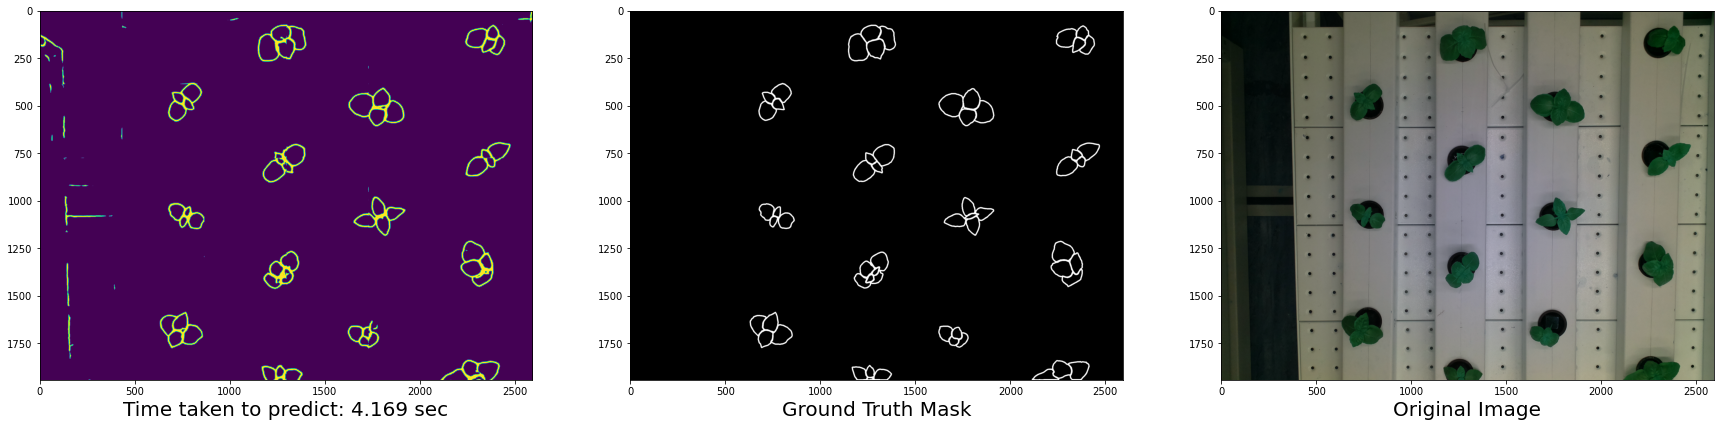

In [ ]:
import matplotlib.pyplot as plt
test_img = cv2.imread(id)
gt_dir = '/content/drive/MyDrive/basil_leaves/annotations_edge_jpg/'
gt_mask_id = gt_dir + id.split('/')[-1][:-4] + '_masked.jpg'
gt_mask = cv2.imread(gt_mask_id)
plt.figure(figsize=(30,30))
plt.subplot(131), plt.imshow(add_mask)
plt.xlabel('Time taken to predict: {:.3f} sec'.format((end-start)), fontsize=20)
plt.subplot(132), plt.imshow(gt_mask)
plt.xlabel('Ground Truth Mask', fontsize=20)
plt.subplot(133), plt.imshow(test_img)
plt.xlabel('Original Image', fontsize=20)

plt.show()

POST-PROCESSING METHODS USING IMAGE PROCESSING

In [ ]:
from skimage.morphology import skeletonize, thin
import pandas as pd
import math
from skimage import morphology
from time import time

def removesmall(imgrs,threshold):
  imglab = morphology.label(imgrs)
  cleaned = morphology.remove_small_objects(imglab, min_size=threshold, connectivity=2)
  # cleaned1 = cv2.fastNlMeansDenoisingColored(result, h=10)
  imgl = np.zeros((cleaned.shape)) # create array of size cleaned
  imgl[cleaned > 0] = 255
  return imgl

14
length of boxlist 14


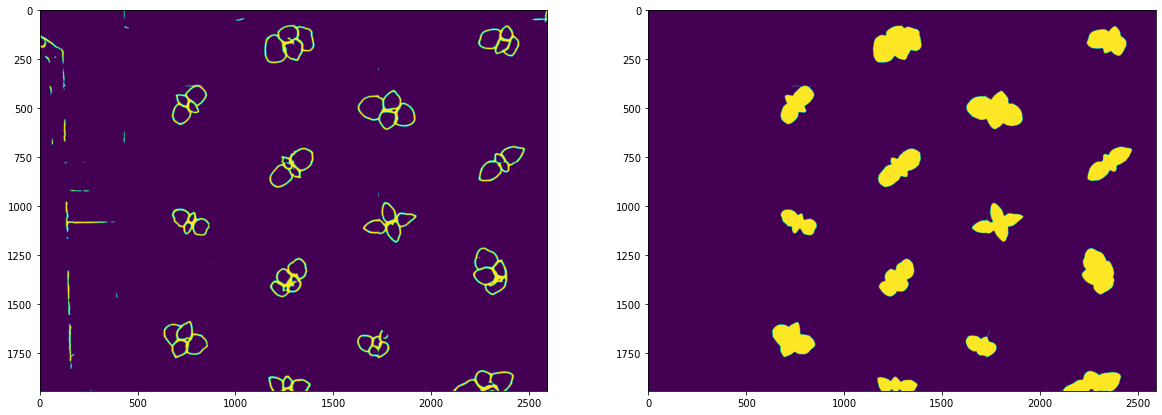

In [ ]:
st = time()
img = add_mask.copy()
# img = img.astype(np.uint8)
img = img*255
thres = cv2.threshold(img,20,255,cv2.THRESH_BINARY)[1]
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
# kernel = np.ones((5,5),np.uint8)
closing = cv2.morphologyEx(thres, cv2.MORPH_CLOSE, kernel, iterations=2)
closing = closing.astype(np.uint8)
bordersize = 2
closing = cv2.copyMakeBorder(
    closing,
    top=0,
    bottom=bordersize,
    left=0,
    right=bordersize,
    borderType=cv2.BORDER_CONSTANT,
    value=255)
# cv2.line(closing,(250,1943),(2590,1943),255,2)
# # cv2.line(thinning,(50,0),(2590,0),255,2)
# # cv2.line(closing,(2592,10),(2592,1940),255,2)
# # erode = cv2.erode(closing, kernel, iterations=1)
thinning = thin(closing)
thinning = thinning.astype(np.uint8)
contours = cv2.findContours(thinning, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]
bmask = np.zeros(img.shape,dtype=np.uint8)
# print(bmask.dtype)
for c in contours:
  cv2.drawContours(bmask, [c], contourIdx = 0, color = 255, thickness=-1)
# print(bmask.dtype)
bmask = removesmall(bmask, 2000)
bmask = bmask.astype(np.uint8)
boxcontour = cv2.findContours(bmask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]
print(len(boxcontour))
boxlist=[]
# plant_area=[]
for c in boxcontour:
  area = cv2.contourArea(c)
  if area>2000:
    x,y,w,h = cv2.boundingRect(c)
    M = cv2.moments(c)
    cx,cy = int(M['m10']/M['m00']), int(M['m01']/M['m00'])
    # print((cx,cy))
    # bmask = cv2.rectangle(bmask,(x,y),(x+w,y+h),255,2)
    boxlist.append((x,y,x+w,y+h,(cx,cy)))
    # plant_area.append(area)

print('length of boxlist {}'.format(len(boxlist)))
plt.figure(figsize = (20,20))
plt.subplot(221), plt.imshow(img)
plt.subplot(222), plt.imshow(bmask)
# plt.subplot(223), plt.imshow(closing)
# plt.subplot(224), plt.imshow(thinning)
# plt.subplot(133), plt.imshow(contour_img)
plt.show()

In [ ]:
cv2.imwrite('/content/drive/MyDrive/basil_leaves/ip_test.jpg', add_mask)

True

This function creates a dataframe with plant id, plant bbox coordinates & centre, leaf id, leaf area, leaf orientation, leaf center, distance of leaf from plant.

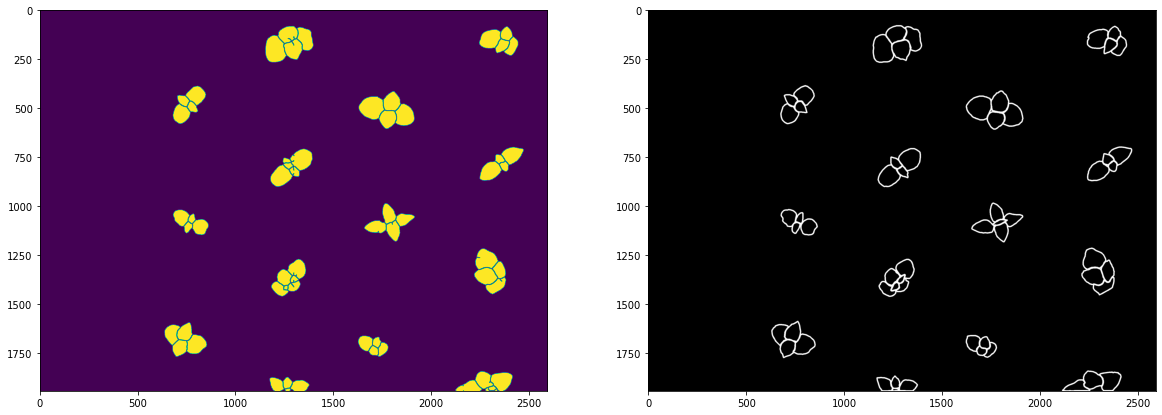

9.024637460708618


In [ ]:
df = pd.DataFrame(columns=['plant id','plant box & centre','leaf id','leaf area','orientation','leaf centre','distance of leaf from plant'])
plants_list=[]
contour_img = cv2.drawContours(bmask.copy(),contours,-1,(0,0,0),2)
contour_img = contour_img.astype(np.uint8)
for i in range(len(boxlist)):
  x1,y1 = boxlist[i][0],boxlist[i][1]
  x2,y2 = boxlist[i][2],boxlist[i][3]
  fillcroppedimg = bmask[y1:y2,x1:x2]
  cx0,cy0=boxlist[i][4]
  cxf,cyf = cx0-x1,cy0-y1
  croppedimg = contour_img[y1:y2,x1:x2]
  cropcontour = cv2.findContours(croppedimg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]
  for id,c in enumerate(cropcontour):
    a = cv2.contourArea(c)
    M = cv2.moments(c)
    cx,cy = int(M['m10']/M['m00']), int(M['m01']/M['m00'])
    myradians = math.atan2(cy-cyf, cx-cxf)
    mydegrees = math.degrees(myradians)
    mydegrees = 180 + (180+mydegrees) if mydegrees<0 else mydegrees
    mydegrees = mydegrees-90
    mydegrees = 270+(90+mydegrees) if mydegrees<0 else mydegrees
    mydegrees = 360-mydegrees
    lcx,lcy = cx+cx0,cy+cy0
    distance = np.linalg.norm(np.array((cx0,cy0)) - np.array((lcx,lcy)))
    dic = {'plant id':i+1,'plant box & centre':boxlist[i],'leaf id':id+1,'leaf area':a,'orientation':mydegrees,
           'leaf centre':(lcx,lcy),'distance of leaf from plant':distance}
    df = df.append(dic,ignore_index=True)
plt.figure(figsize = (20,20))
plt.subplot(221), plt.imshow(contour_img)
plt.subplot(222), plt.imshow(gt_mask)
plt.show()
en = time()
print(en-st)

To see how well leaf has been separated through our model and IP techniques.

61 61


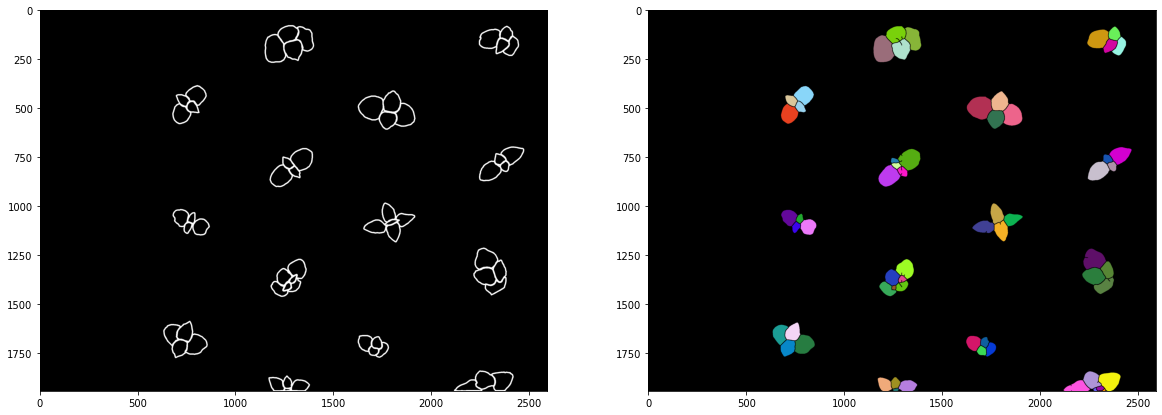

In [ ]:
### only for visualization

mask = np.zeros((*img.shape,3))
fcontours = cv2.findContours(contour_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)[0]
no_of_leaf = 0
leaf_area=[]
for i in range(len(fcontours)):
  if cv2.contourArea(fcontours[i])>1:
    rgb = np.random.rand(3,)
    no_of_leaf+=1
    contour_img1 = cv2.drawContours(mask, fcontours, i, rgb, cv2.FILLED)
  # contour_img2 = cv2.drawContours(maskhull, hull, i, 255, 2)
    leaf_area.append(cv2.contourArea(fcontours[i]))
print(no_of_leaf, len(leaf_area))

plt.figure(figsize = (20,20))
plt.subplot(221), plt.imshow(gt_mask)
plt.subplot(222), plt.imshow(contour_img1)
plt.show()

In [ ]:
# df.to_csv('/content/drive/MyDrive/basil_leaves/'+ids[3].split('/')[-1][:-4]+'.csv')
df

,plant id,plant box & centre,leaf id,leaf area,orientation,leaf centre,distance of leaf from plant
0,1,"(1169, 1871, 1375, 1944, (1266, 1911))",1,265.5,355.601295,"(1361, 1977)",115.676272
1,1,"(1169, 1871, 1375, 1944, (1266, 1911))",2,3934.5,84.193273,"(1422, 1957)",162.640708
2,1,"(1169, 1871, 1375, 1944, (1266, 1911))",3,3605.0,268.090848,"(1303, 1949)",53.037722
3,1,"(1169, 1871, 1375, 1944, (1266, 1911))",4,1860.5,212.005383,"(1358, 1943)",97.406365
4,2,"(2107, 1842, 2413, 1944, (2285, 1899))",1,69.0,46.397181,"(2505, 1996)",240.435022
...,...,...,...,...,...,...,...
56,13,"(2239, 82, 2441, 234, (2345, 157))",4,2969.5,136.636577,"(2485, 196)",145.330657
57,14,"(1148, 75, 1396, 268, (1267, 172))",1,6552.0,42.878904,"(1412, 297)",191.441897
58,14,"(1148, 75, 1396, 268, (1267, 172))",2,10833.0,292.796521,"(1317, 298)",135.558106
59,14,"(1148, 75, 1396, 268, (1267, 172))",3,6646.0,107.241459,"(1473, 242)",217.568380


54 54


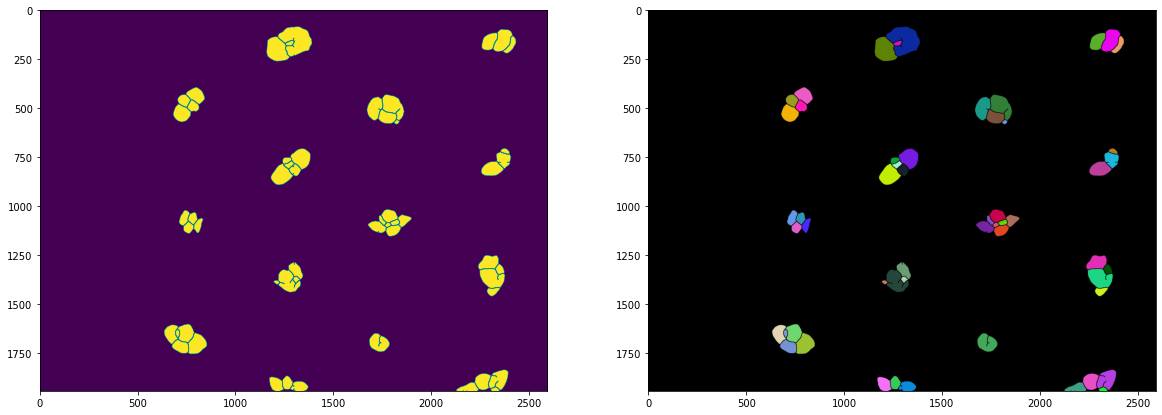

In [ ]:
# img = add_mask.copy()

# # img = img.astype(np.uint8)*255
# img = img*255
# thres = cv2.threshold(img,120,255,cv2.THRESH_BINARY)[1]
# kernel = np.ones((5,5),np.uint8)
# # print(thinning.dtype)
# # thinned_partial = cv2.erode(thinned_partial,kernel,iterations = 1)
# # dil = cv2.dilate(thinning,kernel,iterations = 2)
# closing = cv2.morphologyEx(thres, cv2.MORPH_CLOSE, kernel, iterations=3)
# thinning = thin(closing)
# thinning = thinning.astype(np.uint8)
# # img = img.reshape(*img.shape,1)
# # print(img.shape, img.dtype)
# contours = cv2.findContours(thinning, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)[0]
# max_contour = (sorted(contours, key=cv2.contourArea)[::-1])[0:20]
# # hull=[]
# # [hull.append(cv2.convexHull(max_contour[i], False)) for i in range(len(max_contour))]
# mask = np.zeros((*img.shape,3))
# bmask = np.zeros(img.shape)
# # maskhull = mask.copy()
# for c in contours:
#   contour_img = cv2.drawContours(bmask, [c], contourIdx = 0, color = 255, thickness=-1)
# # polly = cv2.fillPoly(mask,pts=contours,color=(255,255,255))
# contour_img = cv2.drawContours(contour_img,contours,-1,(0,0,0),2)
# contour_img = contour_img.astype(np.uint8)

##checking


# print(contour_img.dtype)
mask = np.zeros((*img.shape,3))
fcontours = cv2.findContours(contour_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)[0]
no_of_leaf = 0
leaf_area=[]
for i in range(len(fcontours)):
  if cv2.contourArea(fcontours[i])>1:
    rgb = np.random.rand(3,)
    no_of_leaf+=1
    contour_img1 = cv2.drawContours(mask, fcontours, i, rgb, cv2.FILLED)
  # contour_img2 = cv2.drawContours(maskhull, hull, i, 255, 2)
    leaf_area.append(cv2.contourArea(fcontours[i]))
print(no_of_leaf, len(leaf_area))

plt.figure(figsize = (20,20))
plt.subplot(221), plt.imshow(contour_img)
plt.subplot(222), plt.imshow(contour_img1)
# plt.subplot(223), plt.imshow(gt_mask)
# plt.subplot(224), plt.imshow(contour_img1)
plt.show()

In [ ]:
# leaf_area

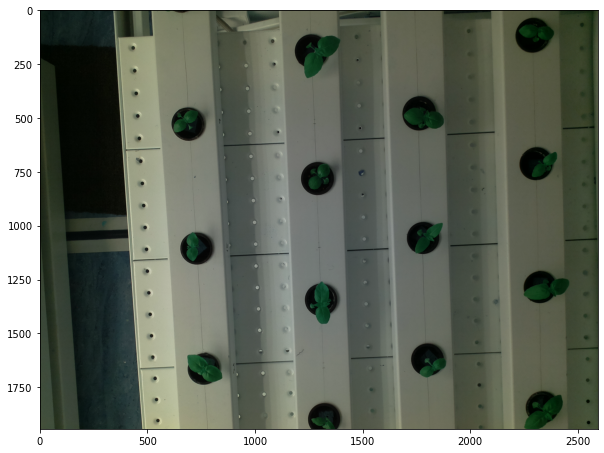

In [ ]:
plt.figure(figsize = (10,10))
plt.imshow(test_img)
plt.show()